# LSTM Modelling 

In [4]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import matplotlib.pyplot as plt
from pprint import pprint

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import GroupKFold

import warnings
warnings.filterwarnings("ignore")

## Data Refactor

In [5]:
dataset = pd.read_csv("../StationsDatasets/dataset.csv").drop(columns=["Unnamed: 0"])

In [6]:
trips = pd.read_csv("../CSVFiles/datatrips.csv").drop(columns=["Unnamed: 0"])

day = []
year = []
for trip in trips.values:
    date = datetime.strptime(trip[0], "%Y-%m-%d %H:%M:%S").timetuple()
    day.append(date.tm_yday)
    year.append(date.tm_year)

trips = trips.drop(columns=["DateEnd"])
trips["Day"] = day
trips["Year"] = year

In [7]:
new_data = pd.DataFrame({"Holiday": [], "Weekday": [], "WeatherSituation": [], "Temp": [], "ATemp": [], "Humidity": [], "Windspeed": []})

for data in dataset.values:
    hour = data[0]
    station = data[1]
    day = data[3]
    year = data[4]

    df = trips.loc[(trips["StationEnd"] == station) & (trips["Day"] == day) & (trips["Year"] == year) & (trips["Hour"] == hour)].values[0][6:-1]
    new_data.loc[len(new_data)] = np.delete(df, 2)

dataset = dataset.join(new_data)

In [8]:
dataset.to_csv("../StationsDatasets/dataset.csv")

## Correlation Features

In [9]:
def featureSelect_dataframe(X, y, criteria, k):

    # initialize our function/method
    reg = SelectKBest(criteria, k=k).fit(X,y)
    
    # transform after creating the reg (so we can use getsupport)
    X_transformed = reg.transform(X)

    # filter down X based on kept columns
    X = X[[val for i,val in enumerate(X.columns) if reg.get_support()[i]]]

    # return that dataframe
    return X, reg.scores_

X = dataset[[col for col in dataset.columns if "Count" not in col]]
y = dataset['Count']

new_x_data = []

# F-value between label/feature for regression tasks.
New_X, scoresX = featureSelect_dataframe(X, y, f_regression, 11)
new_x_data_1 = {list(X.columns)[x]:scoresX[x] for x in range(0,len(list(X.columns)))}
pprint(sorted(new_x_data_1.items(), key=lambda x:x[1], reverse=True))

[('Temp', 7854.233184039789),
 ('ATemp', 7706.912809130377),
 ('Year', 5350.628642028699),
 ('Humidity', 5196.287790444266),
 ('Hour', 2591.040359724638),
 ('WeatherSituation', 1576.8091838740354),
 ('Windspeed', 261.06541187993037),
 ('Day', 225.13003715150458),
 ('StationEnd', 215.19085620330532),
 ('Holiday', 60.46833284115195),
 ('Weekday', 48.945415173314345),
 ('WorkingDay', 35.49851955888466)]


## LSTM

In [19]:
epochs = 1
batch_size = 1
verbose = 2

MSE = [3.744879961013794, 3.711746573448181, 3.7444034814834595, 3.7614252090454103, 3.7319734573364256]

### Method 0
Input: c(t), StationEnd

Output: c(t+1)

In [12]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-19 12:46:51.831909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 12:46:51.832839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 12:46:51.833487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 151s - loss: 3.9338 - accuracy: 0.3223 - 151s/epoch - 827us/step


2023-05-19 12:49:23.169323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 12:49:23.170360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 12:49:23.171014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 149s - loss: 3.7045 - accuracy: 0.3327 - 149s/epoch - 809us/step
183211/183211 - 153s - loss: 3.6657 - accuracy: 0.3341 - 153s/epoch - 837us/step
182778/182778 - 153s - loss: 3.6397 - accuracy: 0.3367 - 153s/epoch - 837us/step
182903/182903 - 153s - loss: 3.6511 - accuracy: 0.3349 - 153s/epoch - 838us/step
183284/183284 - 153s - loss: 3.7192 - accuracy: 0.3328 - 153s/epoch - 833us/step
182908/182908 - 153s - loss: 3.7201 - accuracy: 0.3337 - 153s/epoch - 837us/step
182892/182892 - 153s - loss: 3.7219 - accuracy: 0.3346 - 153s/epoch - 839us/step
182676/182676 - 153s - loss: 3.7251 - accuracy: 0.3340 - 153s/epoch - 837us/step
182421/182421 - 153s - loss: 3.7120 - accuracy: 0.3355 - 153s/epoch - 839us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.406680107116699 - Accuracy: 42.93457269668579%
--------------------------------------------

Text(0.5, 0, 'Methods')

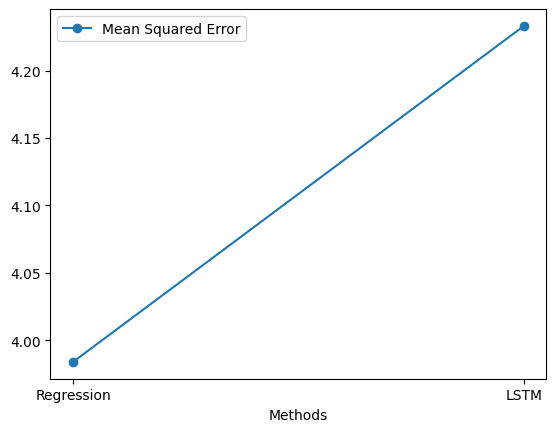

In [2]:
plt.plot(["Regression", "LSTM"], [3.9839102446556587, 1], marker="o")
plt.legend(["Mean Squared Error"])
plt.xlabel("Methods")

### Method 1
Input: ..., Temp

Output: c(t+1)

In [13]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-19 13:12:21.527520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 13:12:21.528445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 13:12:21.529124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 152s - loss: 3.9188 - accuracy: 0.3229 - 152s/epoch - 832us/step


2023-05-19 13:14:53.720752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 13:14:53.722217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 13:14:53.723103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 154s - loss: 3.6890 - accuracy: 0.3331 - 154s/epoch - 836us/step
183211/183211 - 152s - loss: 3.6364 - accuracy: 0.3344 - 152s/epoch - 830us/step
182778/182778 - 152s - loss: 3.6133 - accuracy: 0.3371 - 152s/epoch - 831us/step
182903/182903 - 151s - loss: 3.6022 - accuracy: 0.3357 - 151s/epoch - 828us/step
183284/183284 - 152s - loss: 3.6652 - accuracy: 0.3335 - 152s/epoch - 830us/step
182908/182908 - 152s - loss: 3.6599 - accuracy: 0.3345 - 152s/epoch - 830us/step
182892/182892 - 152s - loss: 3.6456 - accuracy: 0.3352 - 152s/epoch - 829us/step
182676/182676 - 151s - loss: 3.6474 - accuracy: 0.3348 - 151s/epoch - 828us/step
182421/182421 - 152s - loss: 3.6287 - accuracy: 0.3363 - 152s/epoch - 835us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.677389144897461 - Accuracy: 42.968448996543884%
-------------------------------------------

### Method 2
Input: ..., Temp, ATemp

Output: c(t+1)

In [16]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-19 14:49:05.685341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 14:49:05.686758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 14:49:05.687481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 155s - loss: 3.9023 - accuracy: 0.3227 - 155s/epoch - 851us/step


2023-05-19 14:51:41.698081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 14:51:41.699215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 14:51:41.699963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 155s - loss: 3.6181 - accuracy: 0.3330 - 155s/epoch - 840us/step
183211/183211 - 153s - loss: 3.6105 - accuracy: 0.3346 - 153s/epoch - 835us/step
182778/182778 - 154s - loss: 3.5929 - accuracy: 0.3372 - 154s/epoch - 842us/step
182903/182903 - 153s - loss: 3.6055 - accuracy: 0.3357 - 153s/epoch - 837us/step
183284/183284 - 154s - loss: 3.6739 - accuracy: 0.3333 - 154s/epoch - 841us/step
182908/182908 - 155s - loss: 3.6624 - accuracy: 0.3343 - 155s/epoch - 846us/step
182892/182892 - 155s - loss: 3.6689 - accuracy: 0.3351 - 155s/epoch - 848us/step
182676/182676 - 156s - loss: 3.6705 - accuracy: 0.3347 - 156s/epoch - 852us/step
182421/182421 - 155s - loss: 3.6463 - accuracy: 0.3362 - 155s/epoch - 848us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.4749579429626465 - Accuracy: 42.99748241901398%
-------------------------------------------

### Method 3
Input: ..., Temp, ATemp, Hour

Output: c(t+1)

In [18]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-21 15:34:36.407576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 15:34:36.408801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 15:34:36.409533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 164s - loss: 3.8995 - accuracy: 0.3219 - 164s/epoch - 898us/step


2023-05-21 15:37:20.764449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-21 15:37:20.765458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-21 15:37:20.766093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 164s - loss: 3.6356 - accuracy: 0.3323 - 164s/epoch - 888us/step
183211/183211 - 157s - loss: 3.6299 - accuracy: 0.3335 - 157s/epoch - 856us/step
182778/182778 - 171s - loss: 3.5956 - accuracy: 0.3356 - 171s/epoch - 935us/step
182903/182903 - 148s - loss: 3.6068 - accuracy: 0.3334 - 148s/epoch - 811us/step
183284/183284 - 138s - loss: 3.6727 - accuracy: 0.3312 - 138s/epoch - 752us/step
182908/182908 - 139s - loss: 3.6750 - accuracy: 0.3320 - 139s/epoch - 761us/step
182892/182892 - 139s - loss: 3.6777 - accuracy: 0.3327 - 139s/epoch - 758us/step
182676/182676 - 141s - loss: 3.6755 - accuracy: 0.3321 - 141s/epoch - 772us/step
182421/182421 - 139s - loss: 3.6584 - accuracy: 0.3334 - 139s/epoch - 761us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.212751388549805 - Accuracy: 42.98296570777893%
--------------------------------------------

### Method 4
Input: ..., Temp, ATemp, Hour, Humidity

Output: c(t+1)

In [14]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation", "Humidity"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-19 13:37:46.622763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 13:37:46.624020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 13:37:46.625057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 152s - loss: 3.8749 - accuracy: 0.3223 - 152s/epoch - 831us/step


2023-05-19 13:40:18.635742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 13:40:18.636921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 13:40:18.637612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 153s - loss: 3.6219 - accuracy: 0.3328 - 153s/epoch - 827us/step
183211/183211 - 151s - loss: 3.6013 - accuracy: 0.3340 - 151s/epoch - 827us/step
182778/182778 - 152s - loss: 3.5732 - accuracy: 0.3366 - 152s/epoch - 830us/step
182903/182903 - 151s - loss: 3.5881 - accuracy: 0.3350 - 151s/epoch - 824us/step
183284/183284 - 151s - loss: 3.6380 - accuracy: 0.3329 - 151s/epoch - 825us/step
182908/182908 - 151s - loss: 3.6293 - accuracy: 0.3337 - 151s/epoch - 824us/step
182892/182892 - 151s - loss: 3.6126 - accuracy: 0.3345 - 151s/epoch - 827us/step
182676/182676 - 150s - loss: 3.6117 - accuracy: 0.3341 - 150s/epoch - 822us/step
182421/182421 - 150s - loss: 3.5928 - accuracy: 0.3354 - 150s/epoch - 822us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.8461174964904785 - Accuracy: 42.992645502090454%
------------------------------------------

### Method 5
Input: ..., Temp, ATemp, Hour, Humidity, WeatherSituation

Output: c(t+1)

In [15]:
cols = ["StationEnd", "WorkingDay", "Hour", "Count", "Count1", "Count1week", "Count2week", "Count3week", "Temp", "ATemp", "WeatherSituation", "Humidity", "Windspeed"]

met1 = dataset[[col for col in dataset.columns if col in cols]]

X = met1.drop(columns=["Count"])
y = met1["Count"]

X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

# Define the K-fold Cross Validator
kfold = GroupKFold(n_splits=10)

acc_per_fold = []
loss_per_fold = []

model_met1 = Sequential()
model_met1.add(LSTM(4, input_shape=(1,met1.shape[1]-1)))
model_met1.add(Dense(1))
model_met1.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])

# K-fold Cross Validation model evaluation
for train, test in kfold.split(X, y, dataset["StationEnd"]):
    model_met1.fit(X[train], y[train], epochs=epochs, batch_size=batch_size, verbose=verbose)

    # Generate generalization metrics
    scores = model_met1.evaluate(X[test], y[test], verbose=0)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

2023-05-19 14:03:02.740072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 14:03:02.741090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 14:03:02.741754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

182739/182739 - 154s - loss: 3.8353 - accuracy: 0.3228 - 154s/epoch - 840us/step


2023-05-19 14:05:36.538501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-19 14:05:36.539541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-19 14:05:36.540287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

184815/184815 - 154s - loss: 3.6790 - accuracy: 0.3332 - 154s/epoch - 831us/step
183211/183211 - 153s - loss: 3.6819 - accuracy: 0.3344 - 153s/epoch - 835us/step
182778/182778 - 153s - loss: 3.6684 - accuracy: 0.3369 - 153s/epoch - 837us/step
182903/182903 - 154s - loss: 3.6834 - accuracy: 0.3354 - 154s/epoch - 840us/step
183284/183284 - 154s - loss: 3.7215 - accuracy: 0.3328 - 154s/epoch - 841us/step
182908/182908 - 152s - loss: 3.6867 - accuracy: 0.3336 - 152s/epoch - 833us/step
182892/182892 - 153s - loss: 3.6715 - accuracy: 0.3346 - 153s/epoch - 838us/step
182676/182676 - 153s - loss: 3.6677 - accuracy: 0.3343 - 153s/epoch - 837us/step
182421/182421 - 152s - loss: 3.6399 - accuracy: 0.3360 - 152s/epoch - 834us/step
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 4.418654441833496 - Accuracy: 42.99748241901398%
--------------------------------------------

## Graphs

Text(0.5, 0, 'Methods')

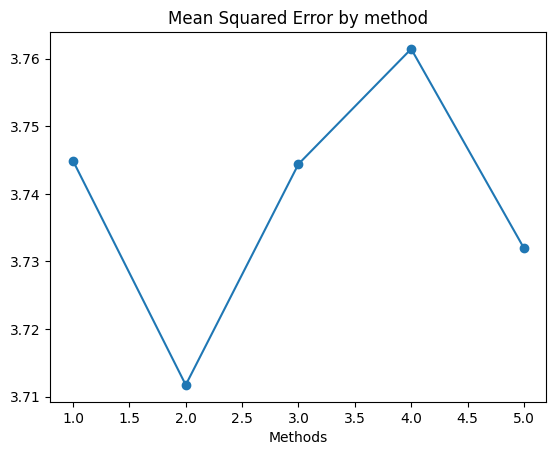

In [20]:
plt.plot(list(range(1,len(MSE)+1)), MSE, marker="o")
plt.title("Mean Squared Error by method")
plt.xlabel("Methods")